In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from matplotlib.pyplot import *
%matplotlib inline
import scipy.stats as scipy
import statsmodels.stats.multitest as multi
 
sns.set_style("ticks")

from IPython.display import set_matplotlib_formats

sys.path.append('/home/felix/jupyter/jupyter_notebooks/functions')

%config Completer.use_jedi = False

In [2]:
import alphafold2_multimer_screen as af2h

## Upload data and make pivot table with averages

In [3]:
merged = pd.read_csv('/home/felix/thesis/chapter5_AF2H/figure3_PredSec_screen_and_select_candidates/screened_dataset_predSecretome/220207_predSecretome_P69B_Pip1_Pepsin_Chit_I_III_V.tsv', sep='\t', index_col=0)
solyc_ids = {'Solyc02g077040.4.1':'Pip1', 'Solyc05g050130.4.1':'Chitinase_Class_III', 'Solyc07g005090.4.1':'Chitinase_Class_V', 'Solyc08g067100.2.1':'Pepsin', 'Solyc08g079870.3.1':'P69B', 'Solyc09g098540.3.1':'Chitinase_Class_I'}
merged.replace({'A':solyc_ids}, inplace=True)

In [4]:
merged = merged[merged.species != 'R_solanacearum_IBSBF_1503']

In [5]:
merged_pivot = merged.pivot_table(values='iptm_ptm', index=["A"], columns="B", aggfunc='mean')
merged_pivot = merged_pivot.fillna(0)
merged_pivot.sort_values(by='A', inplace=True)

# Plot all genes together and hightligh high-scoring best scores per complex

In [9]:
## all_best, _ = af2h.max_iptm(merged, 0.75)

In [10]:
## all_best.to_csv('/home/felix/thesis/chapter5_AF2H/figure3_PredSec_screen_and_select_candidates/all_best.tsv', sep='\t', index=None)

In [11]:
all_best = pd.read_csv('/home/felix/thesis/chapter5_AF2H/figure3_PredSec_screen_and_select_candidates/all_best.tsv', sep='\t')

In [12]:
ibsbf = all_best[all_best.species == 'R_solanacearum_IBSBF_1503'].B.values

In [13]:
pathogen_order = ['PtoDC3000', 'X_perforans', 'R_solanacearum_GMI1000', 'B_cinerea', 'F_oxysporum_f_sp_lycopersici', 'C_fulvum', 'P_infestans']

all_best = all_best[all_best.species != 'R_solanacearum_IBSBF_1503']
all_best.species = all_best.species.astype("category")
all_best.species.cat.set_categories(pathogen_order, inplace=True)
all_best.sort_values(by='species', inplace=True)
all_best.index = range(len(all_best))
all_best['identifier'] = all_best.index

In [14]:
screen_best = all_best.copy()

for i in all_best.index:
    if screen_best.loc[i, 'iptm_ptm'] < 0.75:
        screen_best.drop([i], inplace=True)

In [15]:
grouped_all = all_best.groupby('species')['identifier'].median()

In [16]:
pathogen_labels=['B.cinerea', 'C.fulvum', 'F.oxypsorum f. sp. lyc', 'P.infestans', 'P.syringae pv. tomato', 'R.solanacearum GMI1000', 'X.perforans']

In [17]:
screen_info = pd.read_csv('/home/felix/thesis/chapter5_AF2H/figure3_PredSec_screen_and_select_candidates/screened_dataset_predSecretome/220208_final_candidates.tsv', sep='\t', index_col = 0)
screen_msa = pd.read_csv('/home/felix/thesis/chapter5_AF2H/figure3_PredSec_screen_and_select_candidates/screened_dataset_predSecretome/candidates_scores_overview_combined.tsv', sep='\t', index_col = 0)
all_msa = pd.read_csv('/home/felix/thesis/chapter5_AF2H/figure3_PredSec_screen_and_select_candidates/screened_dataset_predSecretome/all_scores_overview_combined.tsv', sep='\t', index_col = 0)

In [18]:
tested_ids = np.unique(merged.B.to_numpy())

In [19]:
screen_info = screen_info[screen_info.B.isin(tested_ids)]
screen_msa = screen_msa[screen_msa.B.isin(tested_ids)]
all_msa = all_msa[all_msa.B.isin(tested_ids)]

In [20]:
screen_msa.drop(columns=['A', 'B'], inplace=True)

In [21]:
screen = pd.concat([screen_info, screen_msa], axis=1).reindex(screen_info.index)

In [22]:
screen_msa_cov = []

for prot in np.unique(screen.A.values):
    screen_msa_cov.append([prot, np.mean(screen[screen.A == prot]['mean_non_gap_coverage_A'].values), 'target'])

for prot in np.unique(screen.B.values):
    screen_msa_cov.append([prot, np.mean(screen[screen.B == prot]['mean_non_gap_coverage_B'].values), 'effector'])    
    
screen_msa_cov = pd.DataFrame(screen_msa_cov, columns=['Protein', 'mean_non_gap_coverage', 'type']).sort_values(by=['type', 'mean_non_gap_coverage'])
screen_msa_cov.index = range(len(screen_msa_cov))

In [23]:
screen_msa_cov_tar = screen_msa_cov[screen_msa_cov.type == 'target']
screen_msa_cov_eff = screen_msa_cov[screen_msa_cov.type == 'effector']

In [24]:
screen_msa_cov_eff['perc_rank'] = 0

for i in screen_msa_cov_eff.index:
    screen_msa_cov_eff.loc[i, 'perc_rank'] = i/(len(screen_msa_cov_eff)-1)
    
screen_msa_cov_eff['identifier'] = screen_msa_cov_eff.index

<ipython-input-24-947e3551124b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  screen_msa_cov_eff['perc_rank'] = 0
/home/felix/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
<ipython-input-24-947e3551124b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

In [25]:
all_msa_cov = []

for prot in np.unique(all_msa.A.values):
    all_msa_cov.append([prot, np.mean(all_msa[all_msa.A == prot]['mean_non_gap_coverage_A'].values), 'target'])

for prot in np.unique(all_msa.B.values):
    all_msa_cov.append([prot, np.mean(all_msa[all_msa.B == prot]['mean_non_gap_coverage_B'].values), 'effector'])    
    
all_msa_cov = pd.DataFrame(all_msa_cov, columns=['Protein', 'mean_non_gap_coverage', 'type']).sort_values(by=['type', 'mean_non_gap_coverage'])
all_msa_cov.index = range(len(all_msa_cov))

In [26]:
all_msa_cov_tar = all_msa_cov[all_msa_cov.type == 'target']
all_msa_cov_eff = all_msa_cov[all_msa_cov.type == 'effector']

In [27]:
all_msa_cov_tar.index = range(len(all_msa_cov_tar))
all_msa_cov_eff.index = range(len(all_msa_cov_eff))

In [28]:
all_msa_cov_eff['identifier'] = 0
all_msa_cov_eff['perc_rank'] = 0

for i in all_msa_cov_eff.index:
    all_msa_cov_eff.loc[i, 'identifier'] = i
    all_msa_cov_eff.loc[i, 'perc_rank'] = i/(len(all_msa_cov_eff)-1)

<ipython-input-28-25866d088b2a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_msa_cov_eff['identifier'] = 0
<ipython-input-28-25866d088b2a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_msa_cov_eff['perc_rank'] = 0


In [29]:
screen_scores = merged[merged.prot_id.isin(screen.index)]

In [30]:
screen_scores['mean_non_gap_coverage_B'] = 0
screen_scores['candidate_outcome'] = 0
screen_scores['cloned'] = 0




for i in np.unique(screen_scores.prot_id):
    indeces = screen_scores[screen_scores.prot_id == i].index
    values = screen[screen.index == i][['mean_non_gap_coverage_B', 'felix_candidate', 'cloned']].values
    
    screen_scores.loc[indeces, 'mean_non_gap_coverage_B'] = values[0][0]
    screen_scores.loc[indeces, 'candidate_outcome'] = values[0][1]
    screen_scores.loc[indeces, 'cloned'] = values[0][2]
    
screen_scores['cloned'] = screen_scores['cloned'].fillna('no')

<ipython-input-30-471cf4e40037>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  screen_scores['mean_non_gap_coverage_B'] = 0
<ipython-input-30-471cf4e40037>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  screen_scores['candidate_outcome'] = 0
<ipython-input-30-471cf4e40037>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

In [31]:
screen_pos = screen_scores[screen_scores.candidate_outcome == 'yes'].sort_values(by=['A', 'mean_non_gap_coverage_B'])

In [32]:
screen_ids = screen_pos['B'].values
_, idx = np.unique(screen_ids, return_index=True)
effector_labels = screen_ids[np.sort(idx)]

In [33]:
new = []

new.append(['exactly_1', len(all_msa_cov_eff[all_msa_cov_eff.mean_non_gap_coverage == 1])/len(all_msa_cov_eff)])
new.append(['below_10', len(all_msa_cov_eff[all_msa_cov_eff.mean_non_gap_coverage < 10])/len(all_msa_cov_eff)])
new.append(['below_25', len(all_msa_cov_eff[all_msa_cov_eff.mean_non_gap_coverage < 25])/len(all_msa_cov_eff)])
new.append(['below_50', len(all_msa_cov_eff[all_msa_cov_eff.mean_non_gap_coverage < 50])/len(all_msa_cov_eff)])
new.append(['below_75', len(all_msa_cov_eff[all_msa_cov_eff.mean_non_gap_coverage < 75])/len(all_msa_cov_eff)])
new.append(['below_100', len(all_msa_cov_eff[all_msa_cov_eff.mean_non_gap_coverage < 100])/len(all_msa_cov_eff)])

all_cov_fractions = pd.DataFrame(new, columns=['cutoff', 'fraction'])

In [34]:
new = []

new.append(['exactly_1', len(screen_msa_cov_eff[screen_msa_cov_eff.mean_non_gap_coverage == 1])/len(screen_msa_cov_eff)])
new.append(['below_10', len(screen_msa_cov_eff[screen_msa_cov_eff.mean_non_gap_coverage < 10])/len(screen_msa_cov_eff)])
new.append(['below_25', len(screen_msa_cov_eff[screen_msa_cov_eff.mean_non_gap_coverage < 25])/len(screen_msa_cov_eff)])
new.append(['below_50', len(screen_msa_cov_eff[screen_msa_cov_eff.mean_non_gap_coverage < 50])/len(screen_msa_cov_eff)])
new.append(['below_75', len(screen_msa_cov_eff[screen_msa_cov_eff.mean_non_gap_coverage < 75])/len(screen_msa_cov_eff)])
new.append(['below_100', len(screen_msa_cov_eff[screen_msa_cov_eff.mean_non_gap_coverage < 100])/len(screen_msa_cov_eff)])

screen_msa_cov_fractions = pd.DataFrame(new, columns=['cutoff', 'fraction'])

# Plot all together

## Workflow plot

In [35]:
seceff_ids = pd.read_csv('/home/felix/thesis/chapter5_AF2H/figure3_PredSec_screen_and_select_candidates/data/seceff_ids.tsv', sep='\t', index_col=0)
seceff_ids = seceff_ids[seceff_ids.ids.isin(tested_ids)]

In [36]:
targets = np.unique(screen_info.A.values)
categories = []

for i in targets:
    tmp = screen_info[screen_info.A == i]
    
    categories.append(['0', len(tmp[tmp.reclassified == 0]), len(tmp[tmp.reclassified == 0])/len(tmp), i])
    categories.append(['1', len(tmp[tmp.reclassified == 1]), len(tmp[tmp.reclassified == 1])/len(tmp), i])
    categories.append(['2', len(tmp[tmp.reclassified == 2]), len(tmp[tmp.reclassified == 2])/len(tmp), i])
    categories.append(['3', len(tmp[tmp.reclassified == 3]), len(tmp[tmp.reclassified == 3])/len(tmp), i])

categories = pd.DataFrame(categories, columns=['score', 'number', 'fraction', 'target'])

In [37]:
seceff_overview = []

for spec in np.unique(seceff_ids.species.to_numpy()):
    seceff_overview.append([spec, len(seceff_ids[seceff_ids.species == spec])])
    
seceff_overview = pd.DataFrame(seceff_overview, columns=['species', 'putSecretome'])

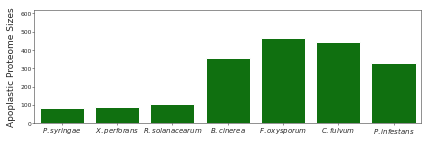

In [38]:
sns.set_style("ticks")

def annotate_axes(axes_list):
    for i, ax in enumerate(axes_list):
        ax.tick_params(axis='both', labelsize=6, pad=0.5)
        # change all spines
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(0.5)
        ax.xaxis.set_tick_params(width=0.5, length=2)
        ax.yaxis.set_tick_params(which='minor', width=0.25, length=2)
        ax.yaxis.set_tick_params(which='major', width=0.5, length=2)


figure = plt.figure(figsize=(6, 2))

apop = plt.subplot2grid((1, 1), (0, 0))

axes = [apop]
annotate_axes(axes)

### Define some arrays ###

species_order = ['P.syringae pv. tomato', 'X.perforans', 'R.solanacearum GMI1000', 'B.cinerea', 'F.oxysporum f. sp. lyc', 'C.fulvum', 'P.infestans']
label_order = ['P.syringae', 'X.perforans', 'R.solanacearum', 'B.cinerea', 'F.oxysporum', 'C.fulvum', 'P.infestans']
label_order = ["$\it{}$".format(x) for x in label_order]

tomato_order = ['Chit.I', 'P69B','Chit.V', 'Chit.III', 'Pepsin', 'Pip1']

pathogen_order = ['PtoDC3000', 'X_perforans', 'R_solanacearum_GMI1000', 'B_cinerea', 'F_oxysporum_f_sp_lycopersici', 'C_fulvum', 'P_infestans']
pathogen_labels = ['P.syringae', 'X.perforans', 'R.solanacearum', 'B.cinerea', 'F.oxysporum', 'C.fulvum', 'P.infestans']
pathogen_labels = ["$\it{}$".format(x) for x in pathogen_labels]



### Generate individual plots ###

sns.set_style("ticks")

sns.barplot(data=seceff_overview, x="species", y="putSecretome", color='green', order=species_order, ax=apop).set(ylim=(0, 620))
apop.set_xlabel('', fontsize=8)
apop.set_ylabel('Apoplastic Proteome Sizes', fontsize=9)
apop.set_xticklabels(label_order)
apop.tick_params(axis='x', rotation=0, labelsize=7)


plt.tight_layout(pad=0.75, h_pad=0.75)
#plt.tight_layout()
#plt.savefig('/home/felix/thesis/chapter5_AF2H/figure3_PredSec_screen_and_select_candidates/corrections/Figure2a_report.png', dpi=200, transparent=True)
plt.show()

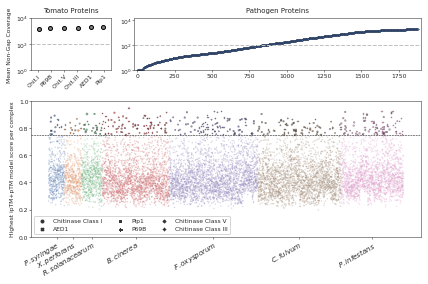

In [39]:
sns.set_style("ticks")

def annotate_axes(axes_list):
    for i, ax in enumerate(axes_list):
        ax.tick_params(axis='both', labelsize=6, pad=0.5)
        # change all spines
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(0.5)
        ax.xaxis.set_tick_params(width=0.5, length=2)
        ax.yaxis.set_tick_params(which='minor', width=0.25, length=2)
        ax.yaxis.set_tick_params(which='major', width=0.5, length=2)


figure = plt.figure(figsize=(6, 4))

msaP = plt.subplot2grid((3, 4), (0, 0))
msaE = plt.subplot2grid((3, 4), (0, 1), colspan=3)
manh = plt.subplot2grid((3, 4), (1, 0), colspan=4, rowspan=2)

axes = [msaP, msaE, manh]
annotate_axes(axes)

### Define some arrays ###


species_order = ['P.syringae pv. tomato', 'X.perforans', 'R.solanacearum GMI1000', 'B.cinerea', 'F.oxysporum f. sp. lyc', 'C.fulvum', 'P.infestans']
label_order = ['P.syringae', 'X.perforans', 'R.solanacearum', 'B.cinerea', 'F.oxysporum', 'C.fulvum', 'P.infestans']
label_order = ["$\it{}$".format(x) for x in label_order]

tomato_order = ['Chit.I', 'P69B','Chit.V', 'Chit.III', 'AED1', 'Pip1']

pathogen_order = ['PtoDC3000', 'X_perforans', 'R_solanacearum_GMI1000', 'B_cinerea', 'F_oxysporum_f_sp_lycopersici', 'C_fulvum', 'P_infestans']
pathogen_labels = ['P.syringae', 'X.perforans', 'R.solanacearum', 'B.cinerea', 'F.oxysporum', 'C.fulvum', 'P.infestans']
pathogen_labels = ["$\it{}$".format(x) for x in pathogen_labels]



### Generate individual plots ###

# MSA coverage of Target proteins
msaP.set_yscale('log')
msaP.set_ylim(1, 10000)
sns.stripplot(data=all_msa_cov_tar, x='Protein', y='mean_non_gap_coverage', s=4, color='grey', edgecolor='black', linewidth=1, ax=msaP)

msaP.set_title('Tomato Proteins', fontsize=7)
msaP.set_xlabel('')
msaP.set_xticks(range(0, 6))
msaP.set_ylabel('Mean Non-Gap Coverage', fontsize=6)
msaP.set_xticklabels(tomato_order, rotation=45, ha='right', rotation_mode="anchor", size=6)
msaP.axhline(100, ls='--', lw=1, color='silver')


# MSA coverage of Effector proteins
msaE.set_yscale('log')
msaE.set_ylim(1, 15000)
msaE.set_xlim(-20, 1900)

sns.scatterplot(data=all_msa_cov_eff, x='identifier', y='mean_non_gap_coverage', s=2, edgecolor='black', linewidth=0.1, ax=msaE)

msaE.set_title('Pathogen Proteins', fontsize=7)
msaE.set_xlabel('')
msaE.set_ylabel('')
msaE.tick_params(axis='x', rotation=0, labelsize=6)
msaE.axhline(100, ls='--', lw=1, color='silver')


# Manhattan plot to find candidates
sns.scatterplot(data=all_best, x='identifier', y='iptm_ptm', hue='species', s=2, color='grey', alpha=0.3, legend=False, hue_order=pathogen_order, ax=manh).set(ylim=(0, 1))
sns.scatterplot(data=screen_best.rename(columns={'A':'Protein Name'}), x='identifier', y='iptm_ptm', hue='species', style='Protein Name', hue_order=pathogen_order, s=3, alpha=0.6, edgecolor='black', linewidth=0.25, legend=True, ax=manh)
handles, labels = manh.get_legend_handles_labels()

manh.set_xlabel('')
manh.set_ylabel('Highest ipTM+pTM model score per complex', fontsize=6)
manh.set_xticks(grouped_all)
manh.set_xticklabels(pathogen_labels)
manh.axhline(0.75, ls='--', lw=0.5, color='black')
manh.set_xticklabels(pathogen_labels, rotation=30, ha='right', rotation_mode="anchor", size=7)
labels = [x.replace("_", " ") for x in labels]
labels = [x.replace("Pepsin", "AED1") for x in labels]
manh.legend(handles[-6:], labels[-6:], ncol=3, loc=3, prop={"size":6}, markerscale=0.5)

plt.tight_layout(pad=0.75, h_pad=0.75)
#plt.tight_layout()
#plt.savefig('/home/felix/thesis/chapter5_AF2H/figure3_PredSec_screen_and_select_candidates/corrections/Figure2b_jupyter.png', dpi=200, transparent=False)
plt.show()

In [40]:
for can in np.unique(screen_best.A):
    print("{}:\t{}".format(can, len(screen_best[screen_best.A == can])))

Chitinase_Class_I:	51
Chitinase_Class_III:	69
Chitinase_Class_V:	27
P69B:	45
Pepsin:	78
Pip1:	106


In [41]:
51+69+27+45+78+106

376

In [42]:
cat = '3'

print(np.sum(categories[categories.score == cat].number))
print(np.sum(categories[categories.score == cat].number.to_numpy())/376)
categories[categories.score == cat]

36
0.09574468085106383


,score,number,fraction,target
3,3,3,0.058824,Chitinase_Class_I
7,3,5,0.072464,Chitinase_Class_III
11,3,1,0.037037,Chitinase_Class_V
15,3,17,0.377778,P69B
19,3,2,0.025641,Pepsin
23,3,8,0.075472,Pip1


# Model Figure 3 with overview of candidates
- [x] heatmap pivot table for all pairwise scores of proteins involved in candidate complexes## Make heatmap pivot table for all pairwise scores of proteins involved in candidate complexes

### Heatmap pivot table for all pairwise scores of proteins involved in candidate complexes## Make heatmap pivot table for all pairwise scores of proteins involved in candidate complexes

In [43]:
effectors = np.unique(screen_pos['B'].values)
cand_pivot = merged[merged.B.isin(effectors)]
cand_pivot = cand_pivot.pivot_table(values='iptm_ptm', index=['A'], columns=['B'], aggfunc='max')

effector_order = []

for i in cand_pivot.index:
    tmp = screen_pos[screen_pos.A == i]['B'].values
    _, idx = np.unique(tmp, return_index=True)
    names = tmp[np.sort(idx)]
    for j in names:
        effector_order.append(j)    
        
cand_annot = screen[screen.B.isin(effectors)]
cand_annot = cand_annot.pivot_table(values='score', index='A', columns='B', aggfunc='max', fill_value='-')
cand_annot = cand_annot.astype(str)

cand_pivot = cand_pivot.reindex(effector_order, axis=1)
cand_annot = cand_annot.reindex(effector_order, axis=1)

### MSA depth data in candidates

In [44]:
keep_cols = ['A', 'felix_candidate', 'avg_score', 'std_score', 'best_model_score', 'mean_non_gap_coverage_B', 'score']

msa_diff = screen[keep_cols]

msa_diff['identifier'] = 'all'

tmp_cand = msa_diff[msa_diff.felix_candidate == 'yes'][keep_cols]
tmp_cand['identifier'] = 'enz_inh'

tmp_zero = msa_diff[msa_diff.score == 0][keep_cols]
tmp_zero['identifier'] = '0'

tmp_one = msa_diff[msa_diff.score == 1][keep_cols]
tmp_one['identifier'] = '1'

tmp_two = msa_diff[msa_diff.score == 2][keep_cols]
tmp_two['identifier'] = '2'

tmp_three = msa_diff[msa_diff.score == 3][keep_cols]
tmp_three['identifier'] = '3'

msa_diff = pd.concat([msa_diff, tmp_zero, tmp_one, tmp_two, tmp_three, tmp_cand])

<ipython-input-44-6e569b20d8ce>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msa_diff['identifier'] = 'all'


### RNAseq and MSA depth data

In [45]:
rna_msa_cands = pd.read_csv('/home/felix/thesis/chapter5_AF2H/figure4_PredSec_Screen_candidates/data/rnaseq_msa_screened_candidates.tsv', sep='\t', names=['prot_id']).prot_id.to_numpy()

In [46]:
rnaseq_show = pd.read_csv('/home/felix/thesis/chapter5_AF2H/figure4_PredSec_Screen_candidates/data/rnaseq_msa_depth_data_six15added.tsv', sep='\t')
rnaseq_show = rnaseq_show[rnaseq_show.species != 'R.solanacearum IBSBF1503']

In [47]:
rnaseq_order = ['KAH3648966.1', 'KAH3652010.1', 'KAH3648855.1', 'XP018236177.1', 'XP018252538.1', 'XP024552256.1', 'XP001552613.1', 'XP018254286.1', 'XP001545484.1', 'WP011002292.1', 'XP018241286.1', 'XP018248187.1', 'WP011000405.1', 'XP001560184.1', 'XP018236493.1', 'KAH3648627.1', 'WP011001815.1', 'XP018243121.1', 'APP91304.1', 'WP008576433.1', 'WP008572913.1', 'WP046931881.1', 'WP046932418.1']
rna_msa_drop = np.setdiff1d(rnaseq_order, rna_msa_cands)

### Bar charts below heatmap to show msa depth of the effector

In [48]:
effectors = np.unique(screen_pos['B'].values)
cand_pivot = merged[merged.B.isin(effectors)]
cand_pivot = cand_pivot.pivot_table(values='iptm_ptm', index=['A'], columns=['B'], aggfunc='max')

effector_order = []

for i in cand_pivot.index:
    tmp = screen_pos[screen_pos.A == i]['B'].values
    _, idx = np.unique(tmp, return_index=True)
    names = tmp[np.sort(idx)]
    for j in names:
        effector_order.append(j)    
        
cand_annot = screen[screen.B.isin(effectors)]
cand_annot = cand_annot.pivot_table(values='score', index='A', columns='B', aggfunc='max', fill_value='-')
cand_annot = cand_annot.astype(str)

effs = cand_pivot.columns
cand_pivot = cand_pivot.reindex(effector_order, axis=1)
cand_annot = cand_annot.reindex(effector_order, axis=1)

cand_pivot.drop(columns=rna_msa_drop, inplace=True)
cand_annot.drop(columns=rna_msa_drop, inplace=True)

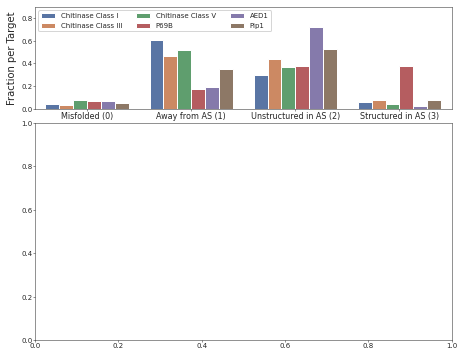

In [49]:
def annotate_axes(axes_list):
    for i, ax in enumerate(axes_list):
        ax.tick_params(axis='both', labelsize=7, pad=0.5)
        # change all spines
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(0.5)
        ax.xaxis.set_tick_params(width=0.5, length=2)
        ax.yaxis.set_tick_params(which='minor', width=0.25, length=2)
        ax.yaxis.set_tick_params(which='major', width=0.5, length=2)


plt.figure(figsize=(6.5, 5))

scor = plt.subplot2grid((3, 1), (0, 0))
imgs = plt.subplot2grid((3, 1), (1, 0), rowspan=2)


axes = [scor, imgs]
annotate_axes(axes)

### Defining some arrays ###
category_labels = ['Misfolded (0)', 'Away from AS (1)', 'Unstructured in AS (2)', 'Structured in AS (3)']

### Generating individual plots

# Overview of scoring
sns.barplot(data=categories, x='score', y='fraction', hue='target', ax=scor)
scor.set_ylim(0, 0.9)
scor.set_xlabel('', fontsize=8)
scor.set_ylabel('Fraction per Target', fontsize=10)
scor.set_xticks(range(0, 4))
scor.set_xticklabels(category_labels, fontsize=8)
handles, labels = scor.get_legend_handles_labels()
labels = [x.replace("_", " ") for x in labels]
labels = [x.replace("Pepsin", "AED1") for x in labels]
scor.legend(handles[-6:], labels[-6:], loc=2, ncol=3, prop={"size":7})


plt.tight_layout(pad=0.75, h_pad=0.001)
#plt.savefig('/home/felix/thesis/chapter5_AF2H/figure4_PredSec_Screen_candidates/corrections/Figure4a_juptyer.svg', transparent=True)
plt.show()

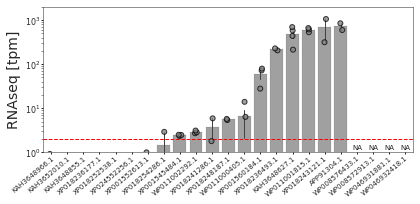

In [50]:
def annotate_axes(axes_list):
    for i, ax in enumerate(axes_list):
        ax.tick_params(axis='both', labelsize=8, pad=0.5)
        # change all spines
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(0.5)
        ax.xaxis.set_tick_params(width=1, length=2)
        ax.yaxis.set_tick_params(which='minor', width=0.5, length=2)
        ax.yaxis.set_tick_params(which='major', width=1, length=2)


plt.figure(figsize=(6, 3))

rnaS = plt.subplot2grid((1, 1), (0, 0))

axes = [rnaS]
annotate_axes(axes)

### Defining some arrays ###

### Generating individual plots

# Plot RNAseq coverage of candidate effectors
rnaS.set_yscale('log')
rnaS.set_ylim(1, 2000)

sns.barplot(data=rnaseq_show, x='prot_id' ,y='value', edgecolor='black', order=rnaseq_order, color='grey', linewidth=0.1, ci=68, errwidth=1, alpha=0.75, dodge=False, ax=rnaS)
sns.stripplot(data=rnaseq_show, x='prot_id' ,y='value', edgecolor='black', order=rnaseq_order, color='grey', linewidth=1, s=5, alpha=0.75, dodge=False, ax=rnaS)

rnaS.set_xticklabels(rnaseq_order, rotation=40, ha='right', rotation_mode="anchor", size=7)
rnaS.set_xlabel('')
rnaS.set_ylabel('RNAseq [tpm]', fontsize=14)
rnaS.axhline(2, ls='--',lw=1, color='red')

for xpos in rnaS.get_xticks()[-4:]:
    rnaS.text(xpos, 1.5, 'NA', size=7, ha='center', va='top')

plt.tight_layout()
#plt.tight_layout(pad=0.75, h_pad=0.001)
#plt.savefig('/home/felix/thesis/chapter5_AF2H/figure5_Orthofinder_overview/corrections/Figure5a_report.png', dpi=200, transparent=True)
plt.show()

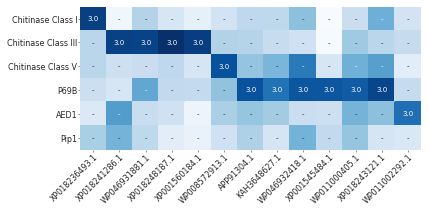

In [51]:
### As of 02.03.2022 - A figure about biol. data to select candidates to test


def annotate_axes(axes_list):
    for i, ax in enumerate(axes_list):
        ax.tick_params(axis='both', labelsize=3, pad=0.5)
        # change all spines
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(0.5)
        ax.xaxis.set_tick_params(width=0.5, length=2)
        ax.yaxis.set_tick_params(which='minor', width=0.25, length=2)
        ax.yaxis.set_tick_params(which='major', width=0.5, length=2)


plt.figure(figsize=(6, 3))

heat = plt.subplot2grid((1, 1), (0, 0))

axes = [heat]
annotate_axes(axes)

### Defining some arrays ###

### Generating individual plots

# Heatmap of all candidates approved for cloning
sns.heatmap(data=cand_pivot, annot=cand_annot.to_numpy(), fmt='', annot_kws={"size": 7}, cmap='Blues', cbar=False, cbar_kws={"use_gridspec":False, "location":"top", "shrink":0.5}, vmin=np.min(cand_pivot.min()), vmax=np.max(cand_pivot.max()), ax=heat)
heat.set_xlabel('', fontsize=8)
heat.set_ylabel('', fontsize=8)
heat.set_yticklabels(['Chitinase Class I', 'Chitinase Class III', 'Chitinase Class V', 'P69B', 'AED1', 'Pip1'], fontsize=8)
heat.set_xticklabels(cand_pivot.columns, rotation=45, ha='right', rotation_mode="anchor", size=8)

#plt.tight_layout()
plt.tight_layout(pad=0.75, h_pad=0.001)
#plt.savefig('/home/felix/thesis/chapter5_AF2H/figure5_Orthofinder_overview/corrections/Figure7_report.svg', transparent=True)
plt.show()